# Fixed Income Risk Monitoring
Code by Lili, Hui Gao \
Lastest Update: Lili, July 31st 2025\
Lastest Update: Lili, Aug 8th 2025\
Lastest Update: Lili, Aug 25th 2025\
Lastest Update: Lili, Aug 27th 2025\
Lastest Update: Lili, Sep 1st 2025


## Project Overview

This project analyzes the **SIAS Fixed Income Portfolio** and its benchmark, the **iShares Core Canadian Universe Bond Index ETF**, to evaluate active positioning, risk exposures, and performance under various yield-curve scenarios.

**Key Steps and Outputs**

1. **Portfolio & Benchmark Overview**

   * Loaded the most recent portfolio (from BNY Mellon) and benchmark data (from [iShares Core Canadian Universe Bond Index ETF](https://www.blackrock.com/ca/investors/en/products/239493/ishares-canadian-universe-bond-index-etf)).
   * Created summary tables of assets, maturities, market values, coupons, and base weights.
   * Calculated **Macaulay duration** for each holding to derive the portfolio’s **active duration**, and measured **active weights** relative to the benchmark.

2. **Allocation Analysis**

   * Categorized holdings into **Federal Bonds**, **Provincial Bonds**, and **Corporate Bonds** for both the portfolio and the benchmark.
   * Compared active weight differences across these categories, with emphasis on federal versus corporate bond allocations.

3. **Stress-Testing Dashboard**

   * **Parallel Shift Stress Test** – Applied yield curve shocks (adjustable in basis points) to estimate P\&L for the portfolio, benchmark, and their active difference.
   * **Curve Steepener/Flattener Test** – Modeled shocks to the short and long ends of the curve to evaluate relative performance under slope changes.
   * **Key Rate Shocks** – Introduced shocks at specific maturities (2Y, 5Y, 10Y, 30Y) to assess sensitivity to localized curve movements.

This workflow provides a clear view of **active duration positioning**, **sector allocation differences**, and **scenario-driven performance**, supporting robust risk assessment and informed portfolio decision-making.

# Code

In [1]:
# ======================== FIXED-INCOME Analysis ========================
# ── 1) Mount Drive & imports ─────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import io, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from google.colab import data_table
import ipywidgets as w
import requests

# Colab dataframe formatter
data_table.enable_dataframe_formatter()
plt.rcParams["figure.dpi"] = 120

# ── 2) CONFIG: UPDATE THESE PATHS if necessary ───────────────────────────────
PORT_FILE  = Path("/content/drive/MyDrive/Colab Notebooks/SIAS_Fixed Income Risk Monitoring/FI Risk Analysis_Shared Folder/20250829 SIAS Asset Detail_30 Aug 2025.xls")
BM_FILE    = Path("/content/drive/MyDrive/Colab Notebooks/SIAS_Fixed Income Risk Monitoring/FI Risk Analysis_Shared Folder/XBB_holdings_Aug 29 2025.csv")
BM_NAME    = "XBB"
PORT_SHEET = None     # set to sheet name if you want to force a specific sheet
ASSET_TAG  = None     # (optional) if your workbook has an asset tag column; unused by default

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1452299059.py:98: RuntimeWarning: invalid value encountered in cast
  n  = np.maximum(np.floor(T * f + 1e-12), 1).astype(int)
/tmp/ipython-input-1452299059.py:108: RuntimeWarning: divide by zero encountered in divide
  scale      = np.where(np.isfinite(P) & (total_pv>0), P / total_pv, 1.0)
/tmp/ipython-input-1452299059.py:98: RuntimeWarning: invalid value encountered in cast
  n  = np.maximum(np.floor(T * f + 1e-12), 1).astype(int)
/tmp/ipython-input-1452299059.py:108: RuntimeWarning: divide by zero encountered in divide
  scale      = np.where(np.isfinite(P) & (total_pv>0), P / total_pv, 1.0)


,Asset,Coupon,Maturity,Market Value,Weight,MacDur
0,PROV OF BRITISH COLUMBIA,6.350,2031-06-18,116168.85,0.014311,4.788657
1,PROV OF BRITISH COLUMBIA,5.700,2029-06-18,197674.46,0.024351,3.235494
2,INVESTORS GROUP INC,6.650,2027-12-13,85698.04,0.010557,1.908460
3,GOVERNMENT OF CANADA,5.750,2033-06-01,227117.55,0.027978,6.307207
4,TORONTO DOMINION BANK,1.888,2028-03-08,119866.96,0.014766,2.452960
5,LOBLAW COMPANIES LTD,5.900,2036-01-18,22052.96,0.002717,7.816915
6,PROV OF ONTARIO,5.850,2033-03-08,229001.88,0.028210,6.279112
7,SCOTIABANK CAPITAL TRUST,5.650,2056-12-31,394116.84,0.048550,15.431994
8,ALTALINK LP,5.249,2036-09-22,119375.90,0.014706,8.598440
9,BMO LONG CORPORATE BD INDEX,0.000,NaT,209249.17,0.025777,12.290000


,Asset,Coupon,Maturity,Market Value,Weight,MacDur
0,CANADA (GOVERNMENT OF),3.25,2035-06-01,1.327804e+08,0.0160,8.249164
1,CANADA (GOVERNMENT OF),3.00,2034-06-01,1.138344e+08,0.0138,7.565632
2,CANADA (GOVERNMENT OF),2.75,2030-03-01,1.117191e+08,0.0135,4.263429
3,CANADA (GOVERNMENT OF),3.50,2029-09-01,1.061775e+08,0.0128,3.767321
4,CANADA (GOVERNMENT OF),2.75,2030-09-01,1.034644e+08,0.0125,4.705602
...,...,...,...,...,...,...
1767,DAIMLER CANADA FINANCE INC,1.65,2025-09-22,1.006500e+03,0.0000,0.500000
1768,BELL CANADA,7.65,2031-12-30,1.161910e+03,0.0000,4.921873
1769,CANADA HOUSING TRUST NO.1 144A,1.95,2025-12-15,1.002100e+03,0.0000,0.500000
1770,TELUS CORPORATION,4.10,2051-04-05,3.606600e+02,0.0000,16.047935


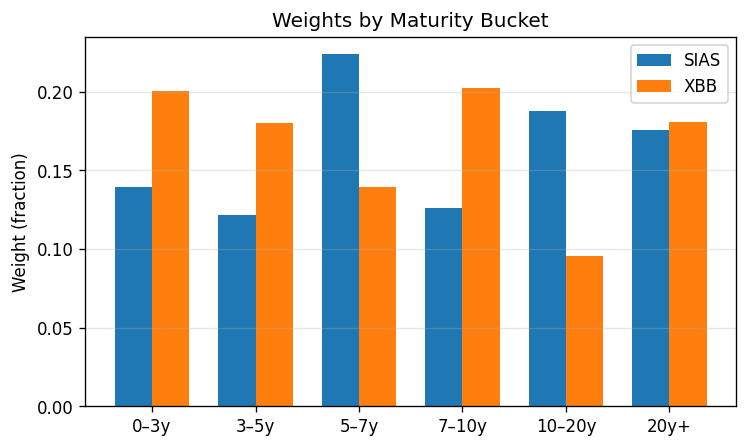

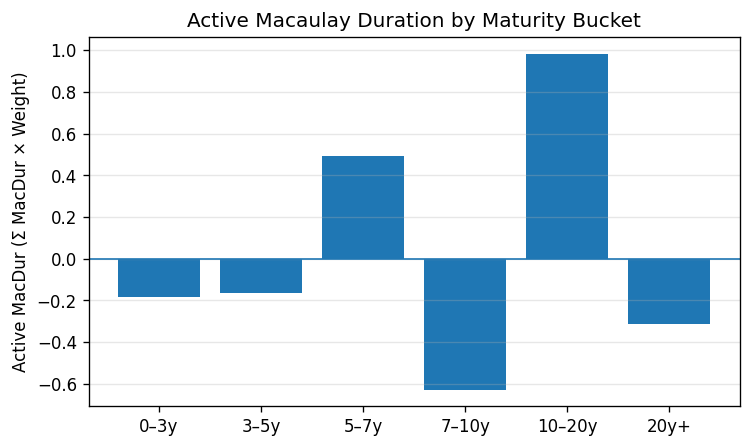

,SIAS (%),XBB (%),Active (pp)
Gov,31.59,30.74,0.85
Province,23.40,31.97,-8.57
Corporate,45.01,37.14,7.87


,SIAS (%),XBB (%),Active (pp)
Government,54.99,62.71,-7.72
Corporate,45.01,37.14,7.87


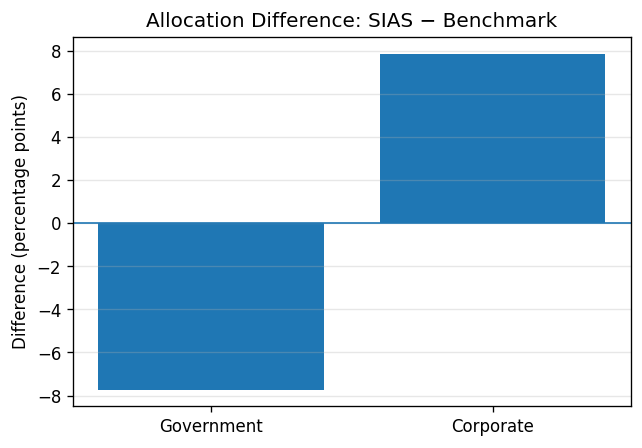

In [3]:
# ── 3) UI helpers (consistent section headings, cards, tables) ───────────────
CSS = """
<style>
.sect h2 {margin: 10px 0 6px;}
.kicker {font-size:12px;color:#666;margin-bottom:4px;letter-spacing:.04em;text-transform:uppercase}
.card {border:1px solid #e5e7eb;border-radius:10px;padding:10px 12px;margin:8px 0;background:#fff}
.badge {display:inline-block;border:1px solid #e5e7eb;border-radius:8px;padding:6px 8px;margin:4px 6px 0 0;background:#fafafa}
.hr {border:none;border-top:1px solid #eee;margin:12px 0}
.h4 {font-weight:600;margin:6px 0}
small.mono {font-family: ui-monospace, SFMono-Regular, Menlo, monospace; color:#666}
</style>
"""
display(HTML(CSS))

def h2(title, kicker=None):
    sub = f"<div class='kicker'>{kicker}</div>" if kicker else ""
    display(HTML(f"<div class='sect'>{sub}<h2>{title}</h2></div>"))

def subtitle(title):
    display(HTML(f"<div class='h4'>{title}</div>"))

def note(msg):
    display(HTML(f"<div class='badge'>{msg}</div>"))

def make_interactive_table(df, cols, title: str, page: int = 25):
    """Polished interactive table with a section title."""
    use_cols = [c for c in cols if c in df.columns]
    view = df.loc[:, use_cols].copy()
    display(HTML(f"<div class='h4'>{title}</div>"))
    tbl = data_table.DataTable(view, include_index=False, num_rows_per_page=page)
    display(tbl)
    return view

def pretty_number(x):
    try:
        return f"{x:,.0f}"
    except Exception:
        return "-"

# ── 4) parsing / numeric helpers ─────────────────────────────────────────────
def _norm(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def _match_col(df: pd.DataFrame, targets):
    if isinstance(targets, str): targets = [targets]
    norm_cols = {_norm(c): c for c in df.columns}
    for t in targets:
        t_norm = _norm(t)
        if t_norm in norm_cols: return norm_cols[t_norm]
    for t in targets:
        t_norm = _norm(t)
        for nc, orig in norm_cols.items():
            if t_norm in nc: return orig
    return None

def _to_datetime(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce").dt.tz_localize(None)

def _to_numeric(v):
    if isinstance(v, pd.Series):
        s = v.copy()
        if hasattr(s, "dtype") and s.dtype.kind in "biufc":
            return pd.to_numeric(s, errors="coerce")
        s = (s.astype(str)
             .str.replace(",", "", regex=False)
             .str.replace("%", "", regex=False)
             .str.replace(r"[\$\s]", "", regex=True)
             .str.strip())
        return pd.to_numeric(s, errors="coerce")
    else:
        if v is None or (isinstance(v, float) and not np.isfinite(v)): return np.nan
        cleaned = re.sub(r"[,\s\$%]", "", str(v)).strip()
        try: return float(cleaned)
        except: return np.nan

def years_to_maturity(maturity: pd.Series, asof: pd.Timestamp) -> pd.Series:
    maturity = pd.to_datetime(maturity, errors="coerce")
    return (maturity - pd.to_datetime(asof)).dt.days / 365.25

# ── 5) Macaulay duration (vectorized) ───────────────────────────────────────
def macaulay_duration(coupon_pct, ytm_pct, years_to_mat, price=100.0, freq=2):
    """
    coupon_pct, ytm_pct in PERCENT; years_to_mat in YEARS; price per 100 par; freq coupons/year.
    Returns Macaulay duration in YEARS. Vectorized; resilient to missing inputs.
    """
    C = np.asarray(_to_numeric(coupon_pct)) / 100.0
    y = np.asarray(_to_numeric(ytm_pct)) / 100.0
    T = np.asarray(_to_numeric(years_to_mat))
    P = np.asarray(_to_numeric(price))
    f = np.asarray(freq if np.isscalar(freq) else _to_numeric(freq))

    y = np.where(~np.isfinite(y), C, y)
    P = np.where(~np.isfinite(P) | (P<=0), 100.0, P)
    f = np.where(~np.isfinite(f) | (f<=0), 2.0, f)

    n  = np.maximum(np.floor(T * f + 1e-12), 1).astype(int)
    dt = 1.0 / f
    cflow = C / f * 100.0
    r  = y / f
    r  = np.where(r==0, 1e-12, r)

    with np.errstate(over='ignore', invalid='ignore'):
        pv_coupons = cflow * (1 - (1 + r) ** (-n)) / r
        pv_par     = 100.0 * (1 + r) ** (-n)
        total_pv   = pv_coupons + pv_par
        scale      = np.where(np.isfinite(P) & (total_pv>0), P / total_pv, 1.0)
        pv_coupons *= scale
        pv_par     *= scale
        total_pv    = pv_coupons + pv_par

        max_n = int(np.nanmax(n)) if np.isfinite(np.nanmax(n)) else 1
        dur_num = np.zeros_like(total_pv)
        for k in range(1, max_n+1):
            tk = k * dt
            m = (k <= n)
            cfk = np.zeros_like(total_pv)
            cfk[m] = cflow[m] * (1 + r[m]) ** (-k) * scale[m]
            dur_num[m] += tk * cfk[m]
        red = 100.0 * (1 + r) ** (-n) * scale
        dur_num += (n * dt) * red
        macdur = np.where(total_pv>0, dur_num / total_pv, np.nan)
    return macdur

# ── 6) Loaders (portfolio & benchmark) ──────────────────────────────────────
def _bond_pv_given_y(y, coupon_rate, years, freq=2, face=100.0):
    if not (np.isfinite(y) and np.isfinite(coupon_rate) and np.isfinite(years) and years > 0 and freq > 0):
        return np.nan
    r = y / freq
    n = max(int(round(years * freq)), 1)
    c = (coupon_rate / 100.0) * face / freq
    if abs(r) < 1e-10:
        return c * n + face / ((1 + r) ** n)
    pv_coupons = c * (1 - (1 + r) ** (-n)) / r
    pv_red = face * (1 + r) ** (-n)
    return pv_coupons + pv_red

def _solve_ytm_from_price(price, coupon_rate, years, freq=2, face=100.0, tol=1e-8, max_iter=100):
    if not (np.isfinite(price) and price > 0 and np.isfinite(coupon_rate) and np.isfinite(years) and years > 0):
        return np.nan
    lo, hi = -0.05, 1.00
    f_lo = _bond_pv_given_y(lo, coupon_rate, years, freq, face) - price
    f_hi = _bond_pv_given_y(hi, coupon_rate, years, freq, face) - price
    expand_steps = 0
    while not (np.isfinite(f_lo) and np.isfinite(f_hi) and f_lo * f_hi < 0) and expand_steps < 20:
        if not np.isfinite(f_lo): lo -= 0.05
        if not np.isfinite(f_hi): hi += 0.50
        if np.isfinite(f_lo) and np.isfinite(f_hi):
            if f_lo > 0 and f_hi > 0: hi += 0.50
            elif f_lo < 0 and f_hi < 0: lo -= 0.05
        f_lo = _bond_pv_given_y(lo, coupon_rate, years, freq, face) - price
        f_hi = _bond_pv_given_y(hi, coupon_rate, years, freq, face) - price
        expand_steps += 1
    if not (np.isfinite(f_lo) and np.isfinite(f_hi) and f_lo * f_hi < 0):
        return np.nan
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = _bond_pv_given_y(mid, coupon_rate, years, freq, face) - price
        if not np.isfinite(f_mid):
            return np.nan
        if abs(f_mid) < tol:
            return max(mid, -0.50)
        if f_lo * f_mid > 0:
            lo, f_lo = mid, f_mid
        else:
            hi, f_hi = mid, f_mid
    return max(0.5 * (lo + hi), -0.50)

def load_portfolio_xlsx(file: Path, sheet: str|None=None):
    file = Path(file)
    if file.suffix.lower() == ".csv":
        df = pd.read_csv(file)
    else:
        xl = pd.ExcelFile(file)
        candidates = xl.sheet_names if sheet is None else [sheet]
        chosen = None
        for sh in candidates:
            try:
                tmp = xl.parse(sh)
            except Exception:
                continue
            hits = 0
            for group in [["name","security","security description","security description 1","description","asset"],
                          ["coupon","cpn","coupon rate"],
                          ["maturity","maturity date","mat date","mty"],
                          ["market value","mv","position mv","marketvalue","local market value","base market value"],
                          ["weight","wgt","port weight","portfolio weight","weight (%)"]]:
                if _match_col(tmp, group): hits += 1
            if hits >= 3:
                chosen = tmp; break
        if chosen is None: chosen = xl.parse(xl.sheet_names[0])
        df = chosen

    c_name     = _match_col(df, ["security description 1","security description","name","security","description","asset"])
    c_coupon   = _match_col(df, ["coupon rate","coupon","cpn"])
    c_maturity = _match_col(df, ["maturity date","maturity","mat date","mty"])
    c_mv       = _match_col(df, ["base market value","market value","local market value","mv","position mv","marketvalue"])
    c_weight   = _match_col(df, ["weight","wgt","port weight","portfolio weight","weight (%)"])
    c_asof     = _match_col(df, ["as of","asof","date","valuation date","pricing date"])
    c_type     = _match_col(df, ["asset type","type","security type","asset class"])
    c_price    = _match_col(df, ["base price","price","clean price","dirty price","close price"])
    c_freq     = _match_col(df, ["frequency","coupon frequency","pay/year","payments per year"])

    rename_map = {}
    if c_name:     rename_map[c_name]     = "Name"
    if c_coupon:   rename_map[c_coupon]   = "Coupon"
    if c_maturity: rename_map[c_maturity] = "Maturity"
    if c_mv:       rename_map[c_mv]       = "MV"
    if c_weight:   rename_map[c_weight]   = "Weight"
    if c_asof:     rename_map[c_asof]     = "AsOf"
    if c_type:     rename_map[c_type]     = "AssetType"
    if c_price:    rename_map[c_price]    = "Price"
    if c_freq:     rename_map[c_freq]     = "Freq"
    df = df.rename(columns=rename_map)

    if "Name" in df.columns:
        df = df[df["Name"].notna()].copy()
    if "AssetType" in df.columns:
        mask_fi = df["AssetType"].astype(str).str.lower().str.contains("fixed income")
        df = df[mask_fi].copy()

    df["Coupon"]   = _to_numeric(df.get("Coupon", np.nan))
    df["Maturity"] = _to_datetime(df.get("Maturity", pd.NaT))
    df["MV"]       = _to_numeric(df.get("MV", np.nan))
    df["Price"]    = _to_numeric(df.get("Price", np.nan))
    df["Freq"]     = _to_numeric(df.get("Freq", np.nan))
    mv_total       = float(np.nansum(df["MV"])) if "MV" in df.columns else np.nan

    if "Weight" in df.columns:
        df["Weight"] = _to_numeric(df["Weight"])
        if df["Weight"].max(skipna=True) > 1.5:
            df["Weight"] = df["Weight"] / 100.0
    else:
        df["Weight"] = np.where(np.isfinite(mv_total) and mv_total > 0, df["MV"]/mv_total, np.nan)

    if "AsOf" in df.columns:
        vals = pd.to_datetime(df["AsOf"], errors="coerce").dropna()
        asof = vals.iloc[0] if not vals.empty else pd.Timestamp.today().normalize()
    else:
        asof = pd.Timestamp.today().normalize()

    yrs = years_to_maturity(df["Maturity"], asof)
    freq_vec = np.where(df["Freq"].notna() & (df["Freq"] > 0), df["Freq"], 2.0).astype(float)

    ytms = []
    for pr, cr, t, f in zip(df["Price"], df["Coupon"], yrs, freq_vec):
        f_eff = int(f) if np.isfinite(f) and f > 0 else 2
        y = _solve_ytm_from_price(pr, cr, t, freq=f_eff)
        ytms.append(y)
    df["Yield"] = ytms  # annual decimal

    df["MacDur"] = macaulay_duration(
        coupon_pct  = df["Coupon"],
        ytm_pct     = pd.Series(df["Yield"]) * 100.0,
        years_to_mat= yrs,
        price       = df["Price"],
        freq        = freq_vec
    )

    ydec = pd.to_numeric(df["Yield"], errors="coerce")
    ydec = ydec.fillna(pd.to_numeric(df["Coupon"], errors="coerce")/100.0)
    freq_safe = np.where(freq_vec > 0, freq_vec, 2.0)
    df["ModDur"] = df["MacDur"] / (1.0 + (ydec / freq_safe))

    def _norm_up(s):
        s = re.sub(r"[^A-Z0-9]+", " ", str(s).upper()).strip()
        return re.sub(r"\s+", " ", s)
    _target = _norm_up("BMO LONG CORPORATE BD INDEX")
    mask_idx = df["Name"].apply(_norm_up) == _target
    # Hard-set known Macaulay duration for this index proxy (can change as needed)
    df.loc[mask_idx, "MacDur"] = 12.29

    keep = ["Name","Coupon","Maturity","Price","Yield","MV","Weight","MacDur","ModDur"]
    for k in keep:
        if k not in df.columns: df[k] = np.nan
    df = df[keep].reset_index(drop=True)
    return df, asof, mv_total

def load_benchmark_xbb(file: Path, asof_fallback: pd.Timestamp):
    text = Path(file).read_text(encoding="utf-8", errors="ignore").splitlines()
    header_idx = None
    for i, line in enumerate(text[:400]):
        if re.search(r"(^|,)\s*Ticker\s*,\s*Name\s*,\s*Sector\s*,\s*Asset Class\s*,", line):
            header_idx = i; break
    if header_idx is None: raise RuntimeError("Could not find the XBB header row.")
    sliced = "\n".join(text[header_idx:])
    raw = pd.read_csv(io.StringIO(sliced), engine="python")

    df = raw.rename(columns={
        "Name"          : "Asset",
        "Market Value"  : "MarketValue",
        "Weight (%)"    : "Weight",
        "Duration"      : "ModDur",
        "Coupon (%)"    : "Coupon",
        "Yield to Maturity (%)": "Yield",
        "Maturity"      : "Maturity",
        "Price"         : "Price"
    }).copy()

    df["MarketValue"] = _to_numeric(df.get("MarketValue", np.nan))
    df["Weight"]      = _to_numeric(df.get("Weight", np.nan)) / 100.0
    df["Coupon"]      = _to_numeric(df.get("Coupon", np.nan))
    df["Yield"]       = _to_numeric(df.get("Yield", np.nan))
    df["Maturity"]    = _to_datetime(df.get("Maturity", pd.NaT))
    df["Price"]       = _to_numeric(df.get("Price", np.nan))

    top_line = text[0] if text else ""
    m = re.search(r"as of[^\w]*(.*)", top_line, flags=re.I)
    bm_asof = pd.to_datetime(m.group(1).strip(), errors="coerce") if m else pd.NaT
    if pd.isna(bm_asof): bm_asof = asof_fallback

    yrs = years_to_maturity(df["Maturity"], bm_asof)
    df["MacDur"] = macaulay_duration(df["Coupon"], df.get("Yield", np.nan), yrs, price=df.get("Price", np.nan), freq=2)

    ydec = _to_numeric(df.get("Yield", np.nan)) / 100.0
    ydec = np.where(np.isfinite(ydec), ydec, _to_numeric(df.get("Coupon", np.nan)) / 100.0)
    df["ModDur"] = df["MacDur"] / (1.0 + (ydec / 2.0))

    mv_total  = float(np.nansum(df["MarketValue"]))
    w_sum     = float(np.nansum(df["Weight"]))

    view_cols = ["Asset","Coupon","Maturity","MarketValue","Weight","MacDur","ModDur"]
    for c in view_cols:
        if c not in df.columns: df[c] = np.nan
    view = df[view_cols].reset_index(drop=True)
    return view, bm_asof, mv_total, w_sum

# ── 7) RUN LOADERS ──────────────────────────────────────────────────────────
port_df, port_asof, port_mv_tot = load_portfolio_xlsx(PORT_FILE, PORT_SHEET)
bm_view, bm_asof, bm_mv_tot, bm_w_sum = load_benchmark_xbb(BM_FILE, port_asof)

# Portfolio aggregates (Macaulay)
port_macdur = float(np.nansum(port_df["MacDur"] * port_df["Weight"]))
bm_macdur   = float(np.nansum(bm_view["MacDur"] * bm_view["Weight"]))
active_macdur = port_macdur - bm_macdur if np.isfinite(bm_macdur) else np.nan

# ── 8) SECTION 1: Portfolio & Benchmark Overview ────────────────────────────
h2("1) Portfolio & Benchmark Overview")
display(HTML(f"""
<div class='card'>
  <div><b>Files</b>:
    <span class='mono'>Portfolio: <small class='mono'>{PORT_FILE.name}</small></span> &nbsp;|&nbsp;
    <span class='mono'>Benchmark: <small class='mono'>{BM_FILE.name}</small></span>
  </div>
  <div style="margin-top:6px"><b>As-of dates</b>:
    <span>Portfolio: <i>{port_asof.date()}</i></span> &nbsp;|&nbsp;
    <span>Benchmark: <i>{bm_asof.date() if pd.notna(bm_asof) else 'N/A'}</i></span>
  </div>
  <div style="margin-top:6px"><b>Totals</b>:
    <span>SIAS MV = <b>{pretty_number(port_mv_tot)}</b></span> &nbsp;|&nbsp;
    <span>{BM_NAME} MV = <b>{pretty_number(bm_mv_tot)}</b></span>
  </div>
  <div style="margin-top:6px"><b>Durations (Macaulay)</b>:
    <span>SIAS = <b>{port_macdur:.2f}</b> yrs</span> &nbsp;|&nbsp;
    <span>{BM_NAME} = <b>{bm_macdur if np.isfinite(bm_macdur) else float('nan'):.2f}</b> yrs</span> &nbsp;|&nbsp;
    <span>Active = <b>{active_macdur if np.isfinite(active_macdur) else float('nan'):.2f}</b> yrs</span>
  </div>
</div>
"""))

# Counts
idx_name = "BMO LONG CORPORATE BD INDEX"
mask_index = port_df["Name"].astype(str).str.upper().str.strip() == idx_name.upper()
port_total_rows = int(port_df.shape[0])
port_rows_ex_index = int(port_df.loc[~mask_index].shape[0])
bm_is_fi = pd.to_datetime(bm_view["Maturity"], errors="coerce").notna()
bm_total_rows = int(bm_is_fi.sum())

display(HTML(f"""
<div class='card'>
  <div class='h4'>Fixed-Income Asset Counts</div>
  <div class='badge'>SIAS (all): <b>{port_total_rows}</b></div>
  <div class='badge'>SIAS (ex-index): <b>{port_rows_ex_index}</b></div>
  <div class='badge'>{BM_NAME} (maturity present): <b>{bm_total_rows}</b></div>
</div>
"""))

# Tables: Portfolio / Benchmark
port_view = port_df.copy()
port_view["Asset"]    = port_view["Name"]
port_view["Maturity"] = pd.to_datetime(port_view["Maturity"], errors="coerce").dt.date
make_interactive_table(
    port_view.rename(columns={"MV":"Market Value"}),
    ["Asset","Coupon","Maturity","Market Value","Weight","MacDur"],
    "Portfolio — Fixed Income Holdings (Macaulay)"
)

bm_tbl = bm_view.copy()
bm_tbl["Maturity"] = pd.to_datetime(bm_tbl["Maturity"], errors="coerce").dt.date
make_interactive_table(
    bm_tbl.rename(columns={"MarketValue":"Market Value"}),
    ["Asset","Coupon","Maturity","Market Value","Weight","MacDur"],
    f"Benchmark ({BM_NAME}) — Holdings (Macaulay)"
)

# ── 9) Active Weights / Duration by Maturity Buckets ────────────────────────
BUCKETS = [(0,3,"0–3y"), (3,5,"3–5y"), (5,7,"5–7y"), (7,10,"7–10y"), (10,20,"10–20y"), (20,100,"20y+")]
BUCKET_LABELS = [b[2] for b in BUCKETS]
bucket_dtype = pd.api.types.CategoricalDtype(BUCKET_LABELS, ordered=True)

def bucketize(df: pd.DataFrame, asof: pd.Timestamp, weight_col="Weight", dur_col="MacDur"):
    yrs = years_to_maturity(df["Maturity"], asof)
    out_w, out_d = [], []
    for lo, hi, label in BUCKETS:
        m = yrs.ge(lo) & yrs.lt(hi)
        w = float(np.nansum(df.loc[m, weight_col]))
        d = float(np.nansum(df.loc[m, dur_col] * df.loc[m, weight_col]))
        out_w.append({"Bucket": label, "Weight": w})
        out_d.append({"Bucket": label, "Dur_weighted": d})
    w_df = pd.DataFrame(out_w).assign(Bucket=lambda x: x["Bucket"].astype(bucket_dtype)).sort_values("Bucket")
    d_df = pd.DataFrame(out_d).assign(Bucket=lambda x: x["Bucket"].astype(bucket_dtype)).sort_values("Bucket")
    return w_df.reset_index(drop=True), d_df.reset_index(drop=True)

bm_asof_eff = bm_asof if pd.notna(bm_asof) else port_asof
port_w_by_bucket, port_dur_c = bucketize(port_df, port_asof)
bm_w_by_bucket,   bm_dur_c   = bucketize(bm_view, bm_asof_eff, weight_col="Weight", dur_col="MacDur")

port_w_by_bucket["Weight"] = port_w_by_bucket["Weight"].fillna(0.0).round(4)
bm_w_by_bucket["Weight"]   = bm_w_by_bucket["Weight"].fillna(0.0).round(4)

# (2) Active Weights by Maturity
h2("2) Active Weights by Maturity", kicker="Allocation Analysis")
fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(BUCKETS))
ax.bar(x-0.18, port_w_by_bucket["Weight"], width=0.36, label="SIAS")
ax.bar(x+0.18, bm_w_by_bucket["Weight"],   width=0.36, label=BM_NAME)
ax.set_xticks(x); ax.set_xticklabels(BUCKET_LABELS)
ax.set_ylabel("Weight (fraction)")
ax.set_title("Weights by Maturity Bucket")
ax.legend(); ax.grid(True, axis="y", alpha=0.3)
plt.show()

# (3) Active Duration by Maturity
h2("3) Active Duration by Maturity", kicker="Duration Positioning")
active_c = (pd.merge(port_dur_c, bm_dur_c, on="Bucket", suffixes=("_SIAS","_BM"))
              .assign(Active_MacDur_contrib=lambda d: d["Dur_weighted_SIAS"] - d["Dur_weighted_BM"]))
active_c["Active_MacDur_contrib"] = active_c["Active_MacDur_contrib"].fillna(0.0).round(4)

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(active_c["Bucket"].astype(str), active_c["Active_MacDur_contrib"])
ax.axhline(0, linewidth=1)
ax.set_ylabel("Active MacDur (Σ MacDur × Weight)")
ax.set_title("Active Macaulay Duration by Maturity Bucket")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

# ── 10) SECTION 4: Bond Allocation & Differences ────────────────────────────
h2("4) Bond Allocation & Differences", kicker="Sector / Issuer Type Mix")

def get_bond_type(name: str) -> str:
    n = str(name).upper()
    if "CANADA" in n and "GOVERNMENT" in n: return "Gov"
    if "PROV OF" in n or "PROVINCE" in n or "ONTARIO" in n or "QUEBEC" in n or "ALBERTA" in n or "BC" in n or "MANITOBA" in n or "SASKATCHEWAN" in n or "NOVA SCOTIA" in n:
        return "Province"
    return "Corporate"

port_df["BondType"] = port_df["Name"].apply(get_bond_type)
bm_view["BondType"] = bm_view["Asset"].apply(get_bond_type)

_port_mix3 = port_df.groupby("BondType")["Weight"].sum()
_bm_mix3   = bm_view.groupby("BondType")["Weight"].sum()
all_types = list(set(_port_mix3.index) | set(_bm_mix3.index))
_port_mix3 = _port_mix3.reindex(all_types, fill_value=0.0)
_bm_mix3   = _bm_mix3.reindex(all_types, fill_value=0.0)

sias_pct = (_port_mix3 * 100).round(2)
bm_pct   = (_bm_mix3 * 100).round(2)
active_pp = (sias_pct - bm_pct).round(2)

mix3_tbl = pd.DataFrame({
    "SIAS (%)": sias_pct,
    f"{BM_NAME} (%)": bm_pct,
    "Active (pp)": active_pp
}, index=["Gov", "Province", "Corporate"]).fillna(0.0)

subtitle("Bond Mix — Gov / Province / Corporate")
display(HTML("<div class='card'></div>"))
display(mix3_tbl)

port_gov  = float(_port_mix3.get("Gov", 0.0) + _port_mix3.get("Province", 0.0))
bm_gov    = float(_bm_mix3.get("Gov", 0.0)   + _bm_mix3.get("Province", 0.0))
port_corp = float(_port_mix3.get("Corporate", 0.0))
bm_corp   = float(_bm_mix3.get("Corporate", 0.0))

sias_gc = np.array([port_gov*100, port_corp*100]).round(2)
bm_gc   = np.array([bm_gov*100,   bm_corp*100]).round(2)
active_gc_pp = (sias_gc - bm_gc).round(2)

govcorp_tbl = pd.DataFrame({
    "SIAS (%)": sias_gc,
    f"{BM_NAME} (%)": bm_gc,
    "Active (pp)": active_gc_pp
}, index=["Government", "Corporate"])

subtitle("Allocation — Government vs Corporate (with Active)")
display(govcorp_tbl)

diff_series = pd.Series({"Government": port_gov - bm_gov, "Corporate": port_corp - bm_corp})
diff_pct = diff_series * 100.0
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(diff_pct.index, diff_pct.values)
ax.axhline(0, linewidth=1)
ax.set_ylabel("Difference (percentage points)")
ax.set_title("Allocation Difference: SIAS − Benchmark")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

# ── 11) SECTION 5: Stress-Test Dashboard ────────────────────────────────────
h2("5) Stress-Test Dashboard", kicker="Scenario Analysis")

# Prep frames
port_stress = port_df.rename(columns={"MV": "MarketValue"}).copy()
port_stress["MarketValue"] = pd.to_numeric(port_stress["MarketValue"], errors="coerce").fillna(0.0)
port_stress["Maturity"]    = pd.to_datetime(port_stress["Maturity"], errors="coerce")
port_stress["MacDur"]      = pd.to_numeric(port_stress.get("MacDur", np.nan), errors="coerce").fillna(0.0)

bmk_stress = bm_view.copy()
bmk_stress["MarketValue"] = pd.to_numeric(bmk_stress.get("MarketValue", 0.0), errors="coerce").fillna(0.0)
bmk_stress["Maturity"]    = pd.to_datetime(bmk_stress["Maturity"], errors="coerce")
bmk_stress["MacDur"]      = pd.to_numeric(bmk_stress.get("MacDur", np.nan), errors="coerce").fillna(0.0)

TOTAL_MV_PORT   = float(port_stress["MarketValue"].sum())
TOTAL_MV_BMK    = float(bmk_stress["MarketValue"].sum())
TOTAL_MV_ACTIVE = TOTAL_MV_PORT
MV_COL, DUR_COL = "MarketValue", "MacDur"
SETTLE_DATE     = pd.Timestamp.today().normalize()

# BoC curve fetch
def get_boc_benchmark_curve():
    url = "https://www.bankofcanada.ca/valet/observations/group/bond_yields_benchmark/json"
    resp = requests.get(url, timeout=15)
    resp.raise_for_status()
    data = resp.json()
    observations = data.get("observations", [])
    meta = data.get("seriesDetail", {})
    if not observations or not meta:
        raise RuntimeError("BoC Valet response missing observations/seriesDetail")
    latest = observations[-1]
    rows = []
    for code, detail in meta.items():
        desc = (detail.get("description") or "").lower()
        label = (detail.get("label") or "").lower()
        if "benchmark bond yield" in desc and ("year" in label or "long-term" in label):
            try:
                term_years = 30.0 if "long-term" in label else float(label.replace(" year", "").strip())
                obs = latest.get(code, {})
                if "v" in obs:
                    rows.append({"Term": term_years, "Yield": float(obs["v"])})
            except Exception:
                continue
    df_curve = pd.DataFrame(rows).sort_values("Term").reset_index(drop=True)
    if df_curve.empty:
        raise RuntimeError("No benchmark yield points parsed from BoC response")
    return df_curve

try:
    curve_df = get_boc_benchmark_curve()
except Exception as e:
    display(HTML(f"<div class='badge'>Warning: BoC curve fetch failed; using flat 3.0% curve. ({e})</div>"))
    curve_df = pd.DataFrame({"Term": [0.5,1,2,3,5,7,10,20,30], "Yield": [3.0]*9})

# Stress P&L helpers
def _tenor_years(series_dates: pd.Series) -> pd.Series:
    return (series_dates - SETTLE_DATE).dt.days.div(365.25)
def _fmt_pct(x: float, base_mv: float) -> str:
    return f"{(x / base_mv * 100.0):+.3f}%"
def pnl_parallel(df: pd.DataFrame, bp: int) -> float:
    return float((df[DUR_COL] * df[MV_COL] * (-bp / 1e4)).sum())
def pnl_twist(df: pd.DataFrame, bp_short: int, bp_long: int, split_yrs: float = 5.0) -> float:
    if "Maturity" not in df: return 0.0
    mat = df["Maturity"]; mask = mat.notna()
    if not mask.any(): return 0.0
    ten = _tenor_years(mat[mask])
    is_short = ten.lt(split_yrs)
    fac_s = -bp_short / 1e4
    fac_l = -bp_long  / 1e4
    dur = df.loc[mask, DUR_COL].astype(float)
    mv  = df.loc[mask, MV_COL].astype(float)
    pnl_s = float((dur[is_short] * mv[is_short] * fac_s).sum())
    pnl_l = float((dur[~is_short] * mv[~is_short] * fac_l).sum())
    return pnl_s + pnl_l

KRD_BUCKETS = [
    (0.0, 3.0,  "2y"),
    (3.0, 7.0,  "5y"),
    (7.0, 15.0, "10y"),
    (15.0, 40.0,"30y"),
]
def pnl_keyrate(df: pd.DataFrame, bucket_bps: dict) -> float:
    if "Maturity" not in df: return 0.0
    mat = df["Maturity"]; mask = mat.notna()
    if not mask.any(): return 0.0
    ten = _tenor_years(mat[mask]).astype(float)
    dur = df.loc[mask, DUR_COL].astype(float)
    mv  = df.loc[mask, MV_COL].astype(float)
    total = 0.0
    for (lo, hi, label) in KRD_BUCKETS:
        bp = int(bucket_bps.get(label, 0))
        if bp == 0: continue
        in_bucket = ten.ge(lo) & ten.lt(hi)
        if not in_bucket.any(): continue
        fac = -bp / 1e4
        total += float((dur[in_bucket] * mv[in_bucket] * fac).sum())
    return total

# (5a) Parallel Shift
# subtitle("5a) Parallel Shift Stress")
sld_parallel = w.IntSlider(value=25, min=-150, max=150, step=5, description="Shock (bp)")
out_parallel = w.Output()

def _run_parallel(_=None):
    with out_parallel:
        out_parallel.clear_output(wait=True)
        s = sld_parallel.value
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(curve_df["Term"], curve_df["Yield"], label="Original", lw=2)
        ax.plot(curve_df["Term"], curve_df["Yield"] + s/100, label=f"Shifted {s:+} bp", lw=2, ls="--")
        ax.set_xlabel("Term (years)"); ax.set_ylabel("Yield (%)")
        ax.set_title("Government of Canada Benchmark Yield Curve")
        ax.grid(True, alpha=0.3); ax.legend()

        p_port = pnl_parallel(port_stress, s)
        p_bmk  = pnl_parallel(bmk_stress , s)

        # Active Rate = (p_port / TOTAL_MV_PORT) - (p_bmk / TOTAL_MV_BMK)
        r_port = p_port / TOTAL_MV_PORT if TOTAL_MV_PORT else np.nan
        r_bmk  = p_bmk  / TOTAL_MV_BMK  if TOTAL_MV_BMK  else np.nan
        r_act  = r_port - r_bmk

        print(f"\nParallel shift  {s:+} bp")
        print(f"  Portfolio ΔPV : {p_port:,.0f}  ({_fmt_pct(p_port, TOTAL_MV_PORT)})")
        print(f"  Benchmark ΔPV : {p_bmk:,.0f}   ({_fmt_pct(p_bmk, TOTAL_MV_BMK)})")
        print(f"  Active   Rate : {r_act:+.2%}")
        plt.show()

sld_parallel.observe(_run_parallel, names="value")
_run_parallel()
box_parallel = w.VBox([sld_parallel, out_parallel], layout=w.Layout(border='1px solid #eee', padding='8px', border_radius='8px'))

# (5b) Curve Steepener / Flattener
# subtitle("5b) Curve Steepener / Flattener Stress")
sld_short = w.IntSlider(value=-10, min=-150, max=150, step=5, description="Short-end (bp)")
sld_long  = w.IntSlider(value= 10, min=-150, max=150, step=5, description="Long-end (bp)")
sld_split = w.FloatSlider(value=5.0, min=1.0, max=15.0, step=0.5, readout_format=".1f",
                          description="Split (yrs)")
out_twist = w.Output()

def _run_twist(_=None):
    with out_twist:
        out_twist.clear_output(wait=True)
        bs, bl, split_yrs = sld_short.value, sld_long.value, sld_split.value
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(curve_df["Term"], curve_df["Yield"], label="Original", lw=2)
        y_twisted = curve_df["Yield"] + np.where(curve_df["Term"] < split_yrs, bs/100, bl/100)
        ax.plot(curve_df["Term"], y_twisted, ls="--", lw=2,
                label=f"Twisted (short {bs:+} bp, long {bl:+} bp)")
        ax.set_xlabel("Term (years)"); ax.set_ylabel("Yield (%)")
        ax.set_title("Government of Canada Benchmark Yield Curve")
        ax.grid(True, alpha=0.3); ax.legend()

        pnl_p = pnl_twist(port_stress, bs, bl, split_yrs)
        pnl_b = pnl_twist(bmk_stress , bs, bl, split_yrs)

        # Active Rate = (pnl_p / TOTAL_MV_PORT) - (pnl_b / TOTAL_MV_BMK)
        r_port = pnl_p / TOTAL_MV_PORT if TOTAL_MV_PORT else np.nan
        r_bmk  = pnl_b / TOTAL_MV_BMK  if TOTAL_MV_BMK  else np.nan
        r_act  = r_port - r_bmk

        print(f"\nSteepener / Flattener  (short {bs:+} bp, long {bl:+} bp, split {split_yrs:.1f}y)")
        print(f"  Portfolio ΔPV : {pnl_p:,.0f}  ({_fmt_pct(pnl_p, TOTAL_MV_PORT)})")
        print(f"  Benchmark ΔPV : {pnl_b:,.0f}   ({_fmt_pct(pnl_b, TOTAL_MV_BMK)})")
        print(f"  Active   Rate : {r_act:+.2%}")
        plt.show()

for s in (sld_short, sld_long, sld_split):
    s.observe(_run_twist, names="value")
_run_twist()
box_twist = w.VBox([w.HBox([sld_short, sld_long, sld_split]), out_twist],
                   layout=w.Layout(border='1px solid #eee', padding='8px', border_radius='8px'))

# (5c) Key-Rate Shocks
# subtitle("5c) Key-Rate Shocks (Bucketed)")
bucket_sliders = {label: w.IntSlider(value=0, min=-150, max=150, step=5, description=f"{label} (bp)")
                  for (_, _, label) in KRD_BUCKETS}
out_krd = w.Output()

def _current_bucket_bps():
    return {label: s.value for label, s in bucket_sliders.items()}

def _run_krd(_=None):
    with out_krd:
        out_krd.clear_output(wait=True)
        bps = _current_bucket_bps()
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(curve_df["Term"], curve_df["Yield"], label="Original", lw=2)
        y_bumped = curve_df["Yield"].copy()
        for (lo, hi, label) in KRD_BUCKETS:
            bp = bps.get(label, 0)
            if bp != 0:
                sel = (curve_df["Term"] >= lo) & (curve_df["Term"] < hi)
                y_bumped.loc[sel] = y_bumped.loc[sel] + bp / 100.0
        ax.plot(curve_df["Term"], y_bumped, ls="--", lw=2, label="Key-rate bumped")
        ax.set_xlabel("Term (years)"); ax.set_ylabel("Yield (%)")
        ax.set_title("Government of Canada Benchmark Yield Curve")
        ax.grid(True, alpha=0.3); ax.legend()

        p_port = pnl_keyrate(port_stress, bps)
        p_bmk  = pnl_keyrate(bmk_stress , bps)

        # Active Rate = (p_port / TOTAL_MV_PORT) - (p_bmk / TOTAL_MV_BMK)
        r_port = p_port / TOTAL_MV_PORT if TOTAL_MV_PORT else np.nan
        r_bmk  = p_bmk  / TOTAL_MV_BMK  if TOTAL_MV_BMK  else np.nan
        r_act  = r_port - r_bmk

        print("Key-Rate Shocks (ΔPV via Σ MacDur in bucket)")
        for label in bps:
            print(f"  {label:<4}: {bps[label]:+} bp")
        print(f"\n  Portfolio ΔPV : {p_port:,.0f}  ({_fmt_pct(p_port, TOTAL_MV_PORT)})")
        print(f"  Benchmark ΔPV : {p_bmk:,.0f}   ({_fmt_pct(p_bmk, TOTAL_MV_BMK)})")
        print(f"  Active   Rate : {r_act:+.2%}")
        plt.show()

for s in bucket_sliders.values():
    s.observe(_run_krd, names="value")
_run_krd()
box_krd = w.VBox([
    w.HBox(list(bucket_sliders.values())),
    out_krd
], layout=w.Layout(border='1px solid #eee', padding='8px', border_radius='8px'))

# Display dashboard blocks
display(w.VBox([
    w.HTML("<div class='card'><div class='h4'>5a) Parallel Shift Stress</div></div>"),
    box_parallel,
    w.HTML("<div class='hr'></div>"),
    w.HTML("<div class='card'><div class='h4'>5b) Curve Steepener / Flattener Stress</div></div>"),
    box_twist,
    w.HTML("<div class='hr'></div>"),
    w.HTML("<div class='card'><div class='h4'>5c) Key-Rate Shocks</div></div>"),
    box_krd
]))
